In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch


In [2]:
d_sorts = ["CD-GraB", "D-RR"]


In [3]:
def exp_maker(n, sorter, seed):
    return f"LR-hmda-{sorter}-lr-0.005-B-16-seed-{seed}"


In [ ]:
results = {s: [] for s in d_sorts}
times = {s: [] for s in d_sorts}

for s in d_sorts:
    for seed in range(5):
        exp_details = exp_maker(4, s, seed)
        exp_folder = f"..{os.sep}..{os.sep}results{os.sep}LR-HMDA{os.sep}{exp_details}"
        r = torch.load(f"{exp_folder}{os.sep}results.pt", map_location='cpu')
        results[s].append(r)
        for rank in range(4):
            time_folder = f"{exp_folder}{os.sep}time{os.sep}"
            times[s].append(torch.load(f"{time_folder}time-{rank}.pt", map_location='cpu'))


In [ ]:
def down_sampling(len_sampling, data):
    start = 0
    end = len_sampling
    len_data = len(data)
    ret = []
    while end <= len_data:
        data_chunk = data[start:end]
        start += len_sampling
        end += len_sampling
        ret.append(torch.mean(torch.as_tensor(data_chunk)))
    return torch.as_tensor(ret)


In [ ]:
def plot_res(ax, s, label, train_test, loss_acc, downsample=False):
    res = []
    for arr in results[s]:
        if downsample:
            if loss_acc == 'acc':
                res.append(down_sampling(2, 100 * torch.tensor(arr[train_test][loss_acc])))
            else:
                res.append(down_sampling(2, torch.tensor(arr[train_test][loss_acc])))
            step = 2
        else:
            if loss_acc == 'acc':
                res.append(100 * torch.tensor(arr[train_test][loss_acc]))
            else:
                res.append(torch.tensor(arr[train_test][loss_acc]))
            step = 1    
    end_pos = len(torch.tensor(results[s][0][train_test][loss_acc])) + 1
    res = torch.vstack(res).numpy()
    mean = res.mean(axis=0)
    std = res.std(axis=0)
    min = res.min(axis=0)
    max = res.max(axis=0)
    ax.plot(np.arange(1, end_pos, step), mean, label=label, markersize=5)
    ax.fill_between(
        np.arange(1, end_pos, step), (mean - std), (mean + std), alpha=0.1)


/tmp/ipykernel_3993622/3224071676.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


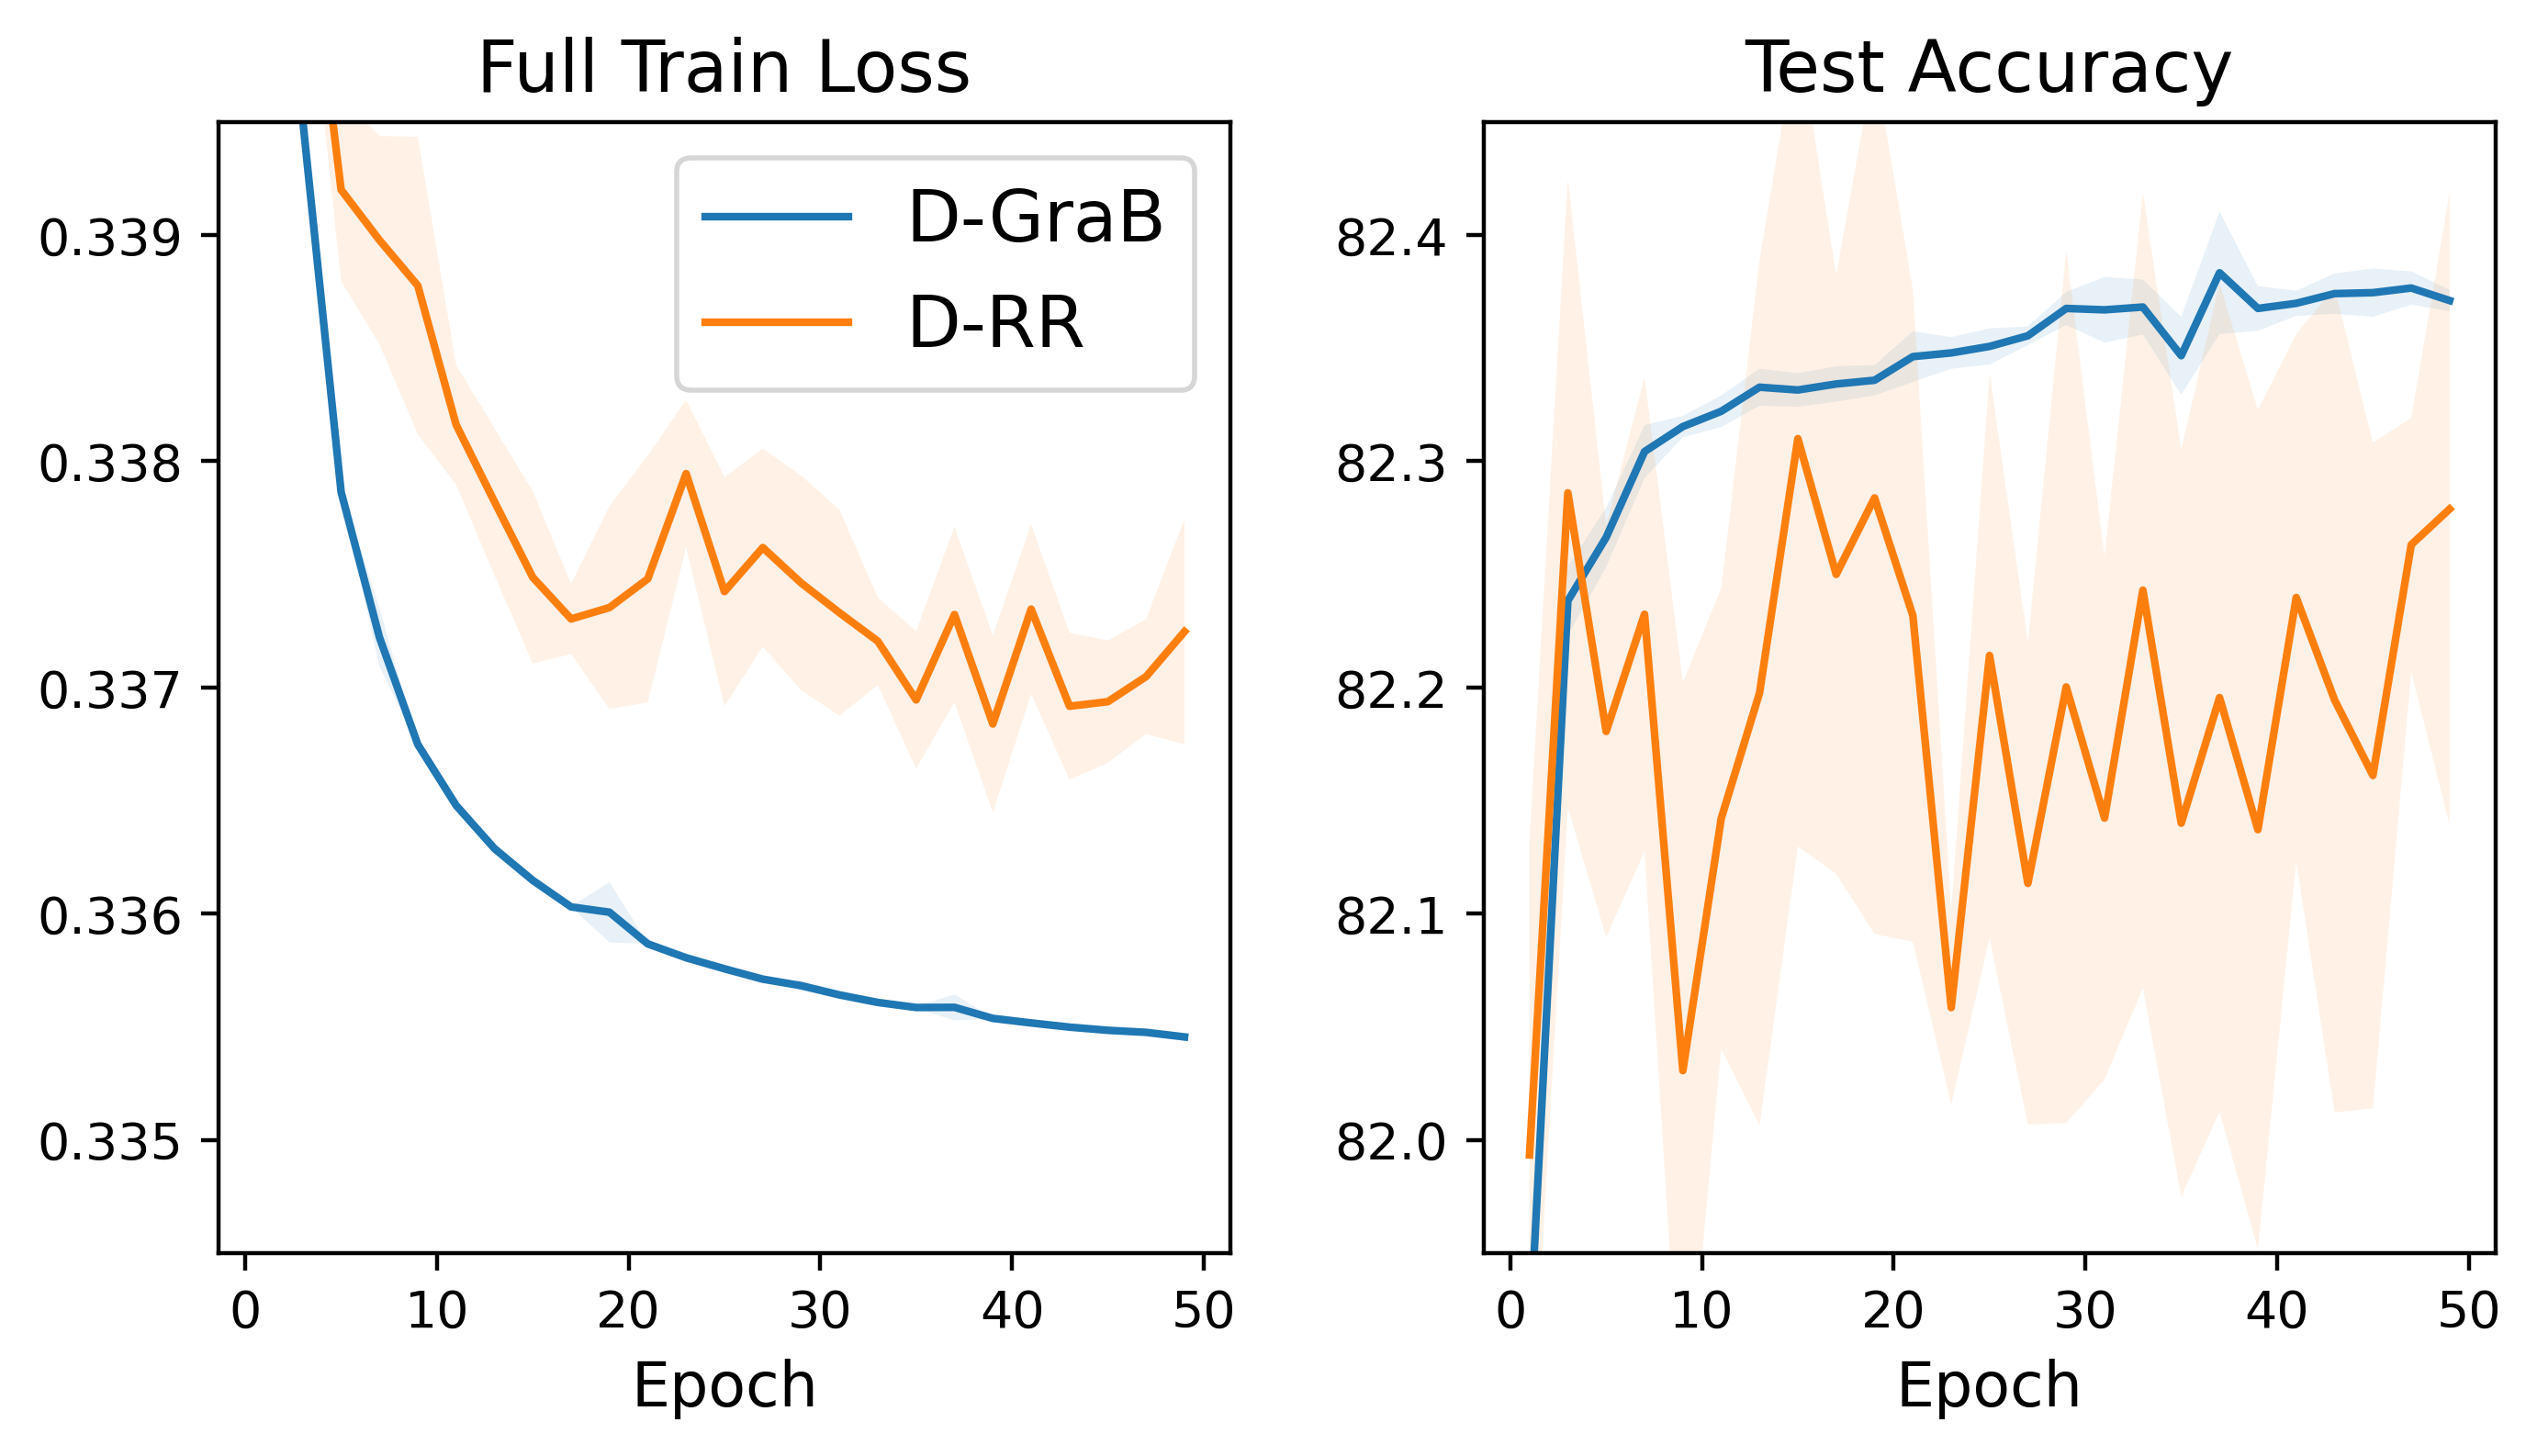

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=400, gridspec_kw=dict(wspace=0.25), sharex=True)

plot_res(axes[0], "CD-GraB", "CD-GraB", "train", 'loss', downsample=True)
plot_res(axes[0], "D-RR", "D-RR", "train", 'loss', downsample=True)

axes[0].legend(fontsize=14, loc='upper right')
axes[0].set_title('Full Train Loss', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylim(0.3345, 0.3395)

plot_res(axes[1], "CD-GraB", "CD-GraB", "test", 'acc', downsample=True)
plot_res(axes[1], "D-RR", "D-RR", "test", 'acc', downsample=True)

axes[1].set_title('Test Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylim(81.95, 82.45)
fig.tight_layout()
fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}HMDA-epoch.png')

In [ ]:
def plot_time(ax, s, label, train_test, loss_acc, downsample=False):
    res = []
    for arr in results[s]:
        if downsample:
            if loss_acc == 'acc':
                res.append(down_sampling(2, 100 * torch.tensor(arr[train_test][loss_acc])))
            else:
                res.append(down_sampling(2, torch.tensor(arr[train_test][loss_acc])))
            step = 2
        else:
            if loss_acc == 'acc':
                res.append(100 * torch.tensor(arr[train_test][loss_acc]))
            else:
                res.append(torch.tensor(arr[train_test][loss_acc]))
            step = 1    
    res = torch.vstack(res).numpy()
    time_res = []
    for time_arr in times[s]:
        one_time = []
        for e in range(1, 51):
            one_time.append(sum(time_arr[f'epoch-{e}']))
        one_time = torch.tensor(one_time) / 1000
        time_res.append(torch.cumsum(one_time, dim=0))
    time_res = torch.vstack(time_res).numpy()
    time_res = time_res.mean(axis=0)
    if downsample:
        time_res = down_sampling(2, time_res)
    mean = res.mean(axis=0)
    std = res.std(axis=0)
    ax.plot(time_res, mean, label=label, markersize=5)
    ax.fill_between(
        time_res, (mean - std), (mean + std), alpha=0.1)


/tmp/ipykernel_3993622/1773564552.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


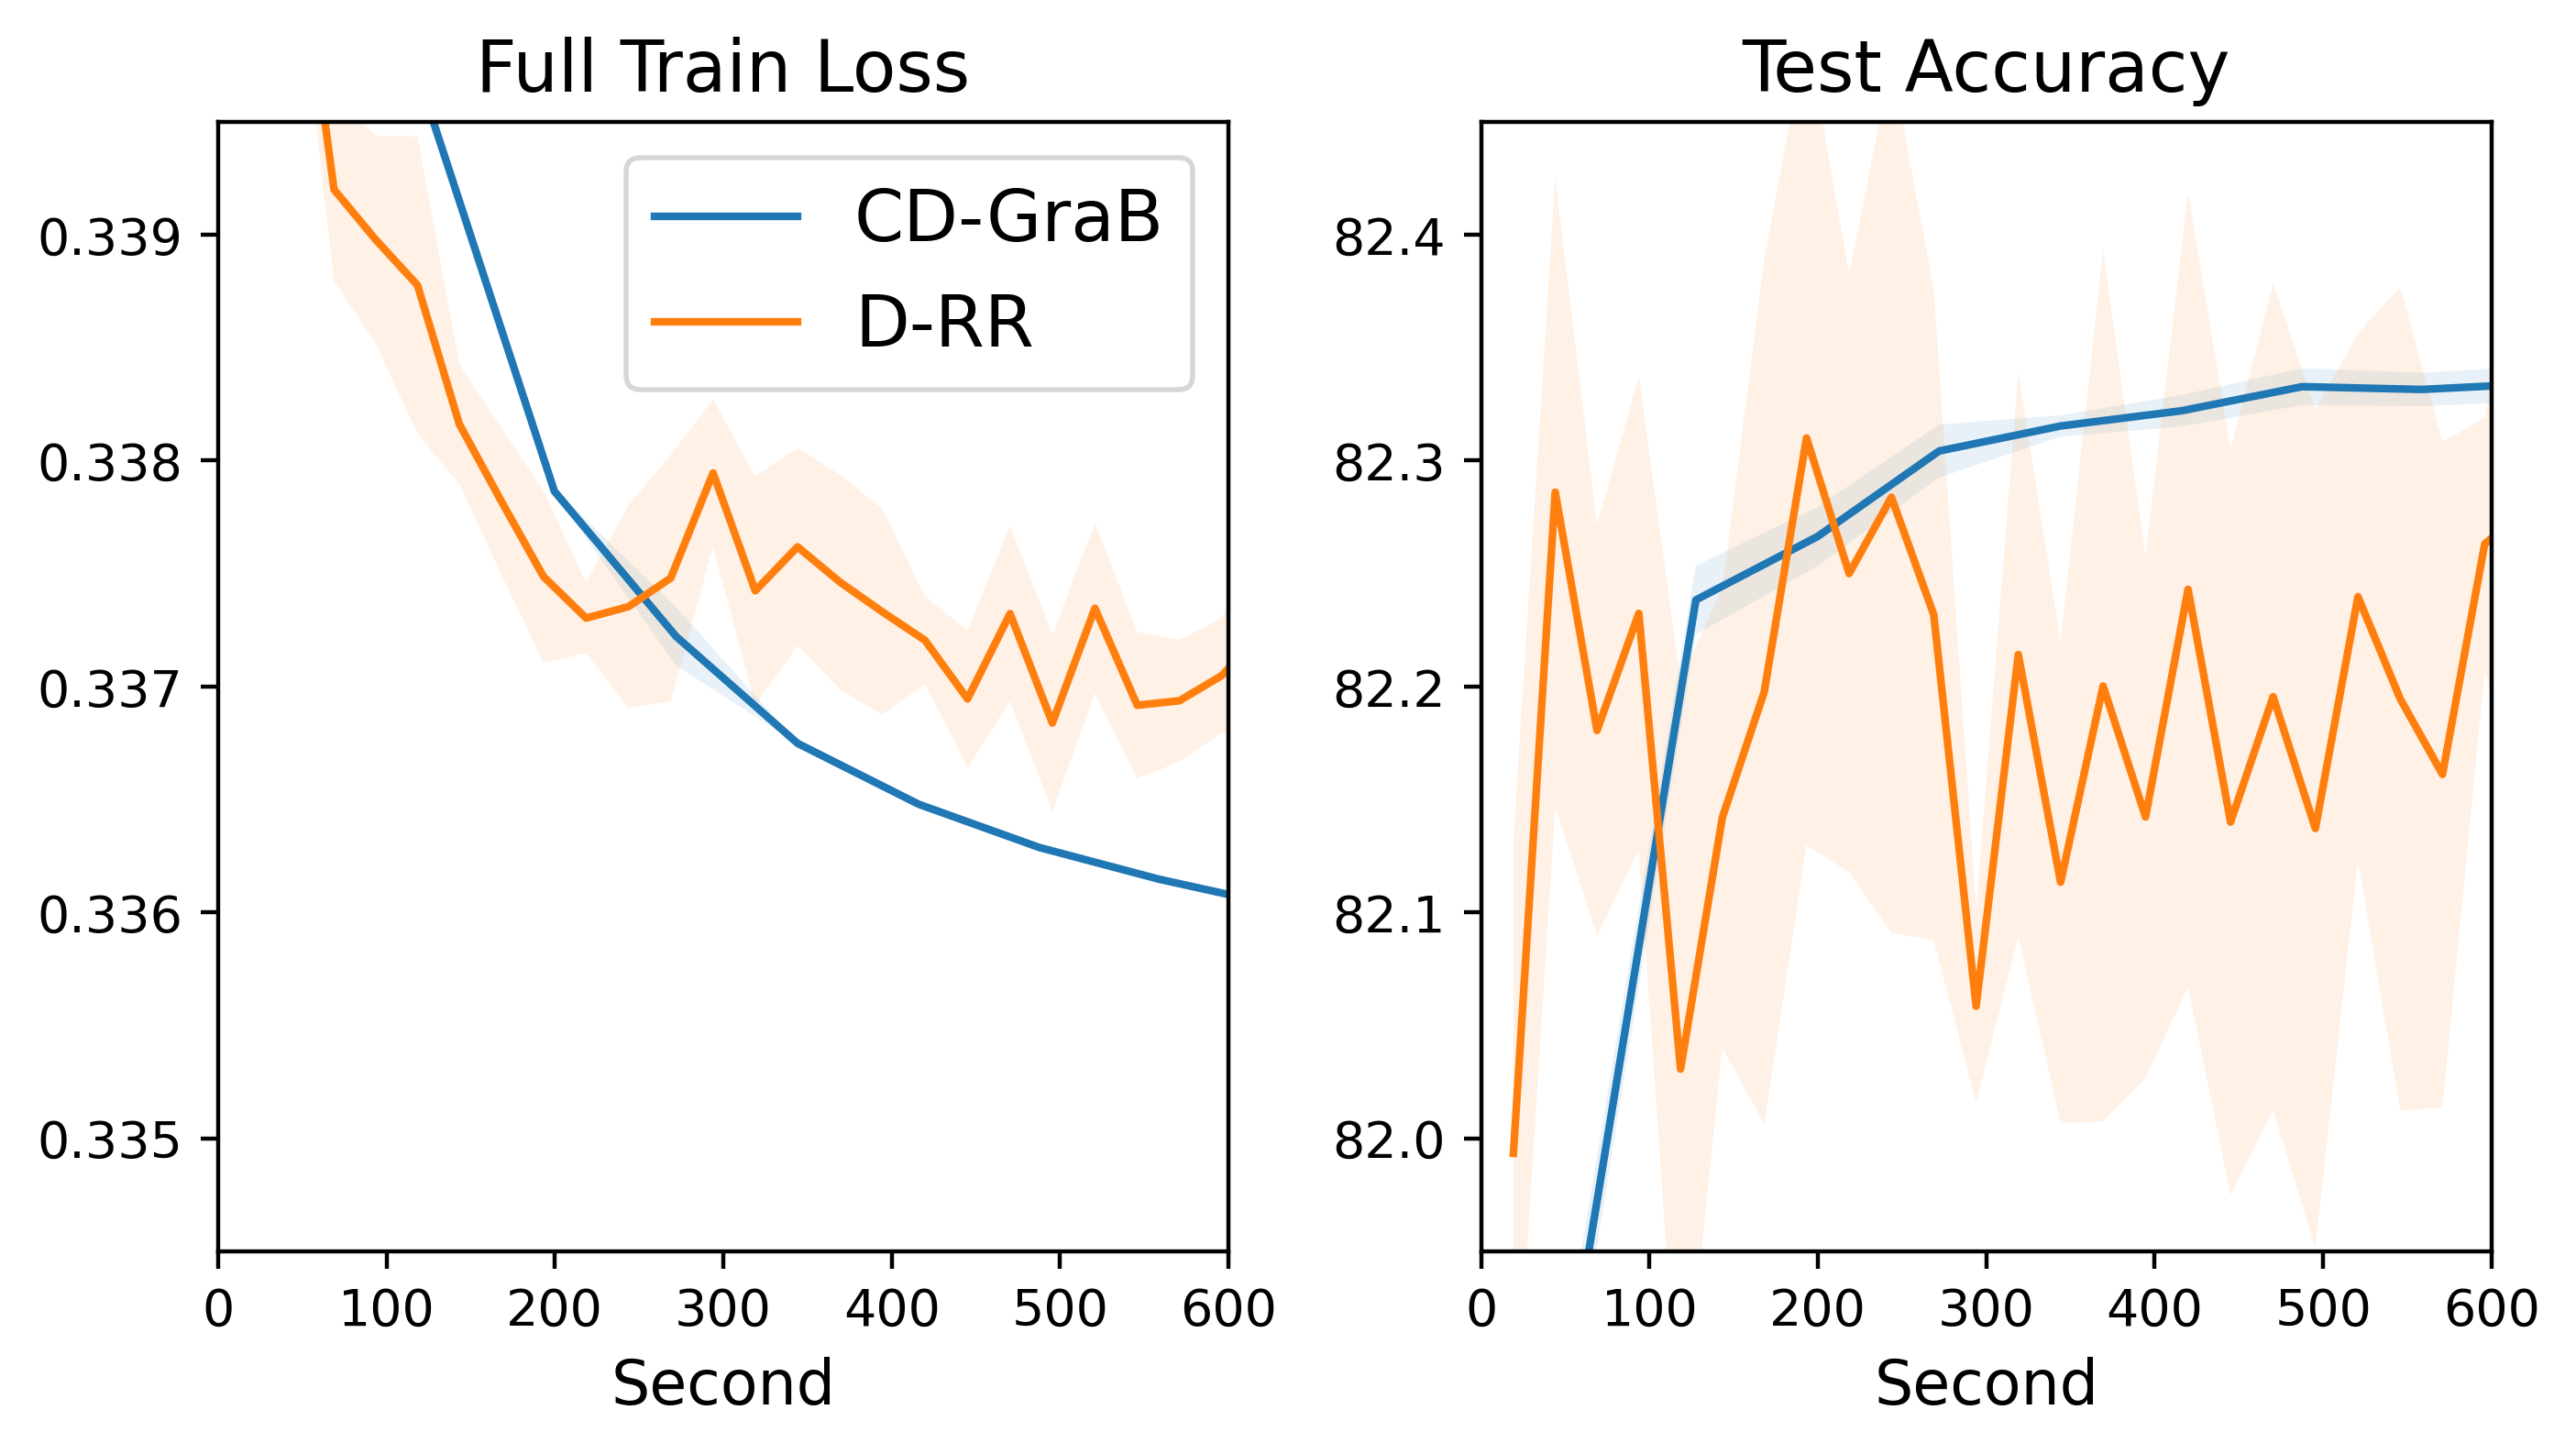

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=400, gridspec_kw=dict(wspace=0.25), sharex=True)

plot_time(axes[0], "CD-GraB", "CD-GraB", "train", 'loss', downsample=True)
plot_time(axes[0], "D-RR", "D-RR", "train", 'loss', downsample=True)

axes[0].legend(fontsize=14, loc='upper right')
axes[0].set_title('Full Train Loss', fontsize=14)
axes[0].set_xlabel('Second', fontsize=12)
axes[0].set_xlim(0, 600)
axes[0].set_ylim(0.3345, 0.3395)

plot_time(axes[1], "d-pb", "CD-GraB", "test", 'acc', downsample=True)
plot_time(axes[1], "d-rr", "D-RR", "test", 'acc', downsample=True)

axes[1].set_title('Test Accuracy', fontsize=14)
axes[1].set_xlabel('Second', fontsize=12)
axes[1].set_xlim(0, 600)
axes[1].set_ylim(81.95, 82.45)

fig.tight_layout()
fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}HMDA-second.png')